# Algorithmic Fairness, Accountability and Ethics
## Assignment 2
Kamil Kojs, Janos Mate, Jorge del Pozo

In [2]:
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, \
                                confusion_matrix,  accuracy_score, precision_score, \
                                    recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from numpy.testing import assert_array_almost_equal
import scipy
from scipy.optimize import fmin_tnc
import math
import os
try:
    import seaborn as sns
    sns.set()
except:
    print("Run without Seaborn")


### 1. Load and Preprocess the data
We are going to work with the [Folktables](https://github.com/socialfoundations/folktables#quick-start-examples) dataset (*you have already worked with it*).

1. As last week, we are still predicting the *Total person's income*  (I've digitized  it in  `target_transform=lambda x: x > 25000`).
2. Today, we are going to implement two methods for data debiasing: [Fair PCA](https://deepai.org/publication/efficient-fair-pca-for-fair-representation-learning) and [A Geometric Solution to Fair Representations](https://dl.acm.org/doi/10.1145/3375627.3375864).
3. We are going to evaluate the performance on two sensitive features: `SEX` (i.e. *Males* and *Females*) and `RAC1P` (we will consider only *Whites* and *African-Americans*)
4. I updated the filtering method `adult_filter` to keep the specified groups.

In [3]:
data_source = ACSDataSource(
    survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
mm_scalar = MinMaxScaler()


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3]  # keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'CIT',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P'
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,
    group=['SEX', "RAC1P"],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)


## Task 1 - Bias Analysis

For the task 1 we should use data, which is not hot-encoded

In [ ]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(
    features=ACSIncomeNew.features, definition_df=definition_df)

features_for_analysis, labels_for_analysis, groups_for_analysis = ACSIncomeNew.df_to_pandas(
    acs_data, categories=categories)
features_for_analysis.head()

In [ ]:
def split_dataset(features, labels, groups, N=20000):

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

    N = 20000  # Subsampling due to speed

    X_train = X_train[:N]
    y_train = y_train[:N]
    group_train = group_train[:N]
    X_test = X_test[:N]
    y_test = y_test[:N]
    group_test = group_test[:N]

    return X_train, X_test, y_train, y_test, group_train, group_test

X_train_for_analysis, X_test_for_analysis, y_train_for_analysis, y_test_for_analysis, group_train_for_analysis, group_test_for_analysis = split_dataset(
    features_for_analysis, labels_for_analysis, groups_for_analysis, N=20000)

In [ ]:
dataset_for_analyses = pd.DataFrame({'AGEP': X_train_for_analysis[:, 0], 'COW': X_train_for_analysis[:, 1], 
                       'SCHL': X_train_for_analysis[:, 2], 'MAR': X_train_for_analysis[:, 3], 'CIT': X_train_for_analysis[:, 4], 'RELP': X_train_for_analysis[:, 5],
                       'WKHP': X_train_for_analysis[:, 6], 'PWGTP': X_train_for_analysis[:, 7], 'SEX': X_train_for_analysis[:, 8],
                        'RAC1P': X_train_for_analysis[:, 9]})
dataset_for_analyses['PINCP'] = y_train_for_analysis.tolist()
dataset_for_analyses.head()

### Task 1.1.: Data Collection and Representation

**1. Discuss sources of bias in the dataset and in the selected features.**

In [ ]:
sns.displot(dataset_for_analyses, x="AGEP", bins=12)

In [ ]:
sns.displot(dataset_for_analyses, x="WKHP", bins=10)

In [ ]:
sns.displot(dataset_for_analyses, x="PWGTP", bins=15)

In [ ]:
import matplotlib.pyplot as plt
for col in dataset_for_analyses[["COW", "SCHL", "MAR", "CIT", "RELP", "SEX", "RAC1P", "PINCP"]]:
    plt.figure().set_figwidth(15)
    dataset_for_analyses[col].value_counts().plot(kind='bar')
    plt.title(f"Value counts for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
plt.show()
#from 1994

**2. Cover the following aspect: Training Data (refer to the Lecture 5 Slide #56: How to handle bias?**

Training data is the data used to train machine learning algorithms and models. If the training data is biased against protected classes, then the resulting models and algorithms may perpetuate that bias and systematically disadvantage those classes.

For example, consider a facial recognition algorithm that is trained on a dataset that is predominantly made up of images of white individuals. If the algorithm is then used to identify faces of individuals from other racial or ethnic groups, it may not perform as well and may have higher rates of false positives or false negatives for those groups. This could result in individuals from those groups being wrongly identified or excluded from certain opportunities, such as access to public services or employment.

Another example is a language model that is trained on text from a specific demographic group or culture. If the model is then used to generate text or make predictions for individuals from other groups, it may not accurately capture their language or cultural nuances, resulting in biased or inappropriate outputs.

To address these issues, it is important to ensure that training data is diverse and representative of all relevant groups. This can involve collecting additional data, using data augmentation techniques, or pre-processing the data to remove or balance any biases. Additionally, it is important to regularly evaluate the performance of models and algorithms to identify and address any biases that may have been introduced through the training data.)

### Task 1.2.: Proxies

**1. Look at feature distributions if you split them by SEX groups (for Males and Females, separately).
Do you see any potential sources of bias? Provide arguments.**

for sex

In [ ]:
for col in ['AGEP', 'WKHP', 'PWGTP']:
    #sns.catplot(data=dataset_for_analyses, y=col, hue="SEX", kind="count",palette="pastel", edgecolor=".6", orient ="h", height=8.27, aspect=11.7/8.27)
    sns.displot(dataset_for_analyses, x=col, hue="SEX", kind="kde", fill=True)
    plt.title(f"Value counts for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
plt.show()

In [ ]:
for col in ['RAC1P', 'MAR', 'SCHL', 'CIT', 'COW', 'PINCP']:
    sns.catplot(data=dataset_for_analyses, y=col, hue="SEX", kind="count",palette="pastel", edgecolor=".6", orient ="h", height=8.27, aspect=11.7/8.27)
    plt.title(f"Value counts for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
plt.show()

for RAC1P

In [ ]:
for col in ['AGEP', 'WKHP', 'PWGTP']:
    sns.displot(dataset_for_analyses, x=col, hue="RAC1P", kind="kde", fill=True)
    plt.title(f"Value counts for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
plt.show()

In [ ]:
for col in ['SEX', 'MAR', 'SCHL', 'CIT', 'COW', 'PINCP']:
    sns.catplot(data=dataset_for_analyses, y=col, hue="RAC1P", kind="count",palette="pastel", edgecolor=".6", orient ="h", height=8.27, aspect=11.7/8.27)
    plt.title(f"Value counts for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
plt.show()

**2. Look at the correlations between SEX and other variables.**

**5. When discussing correlations, do not forget to use the correct metric (e.g. continuous-categorical
features etc.). You can use dython.nominal.associations and seaborn.heatmap.**

CramerV for categorical variables

In [ ]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
label_encoded = pd.DataFrame() 

for i in dataset_for_analyses[['RAC1P', 'SEX', 'SCHL', 'CIT', 'COW', 'PINCP']]:
  label_encoded[i]=label.fit_transform(dataset_for_analyses[i])

In [ ]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [ ]:
rows= []

for var1 in label_encoded:
  col = []
  for var2 in label_encoded :
    cramers =cramers_V(label_encoded[var1], label_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
cr = pd.DataFrame(cramers_results, columns = label_encoded.columns, index =label_encoded.columns)
cr

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.zeros_like(cr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  ax = sns.heatmap(cr)
plt.show()

Point-biserial correlation coefficient for categorical variables

for sex

In [ ]:
from scipy import stats

point_label_encoded = pd.DataFrame() 
point = dataset_for_analyses[['SEX', 'AGEP','WKHP', 'PWGTP']]
point
for i in point.columns:
  point_label_encoded[i]=label.fit_transform(dataset_for_analyses[i])
print(stats.pointbiserialr(point_label_encoded['AGEP'], point_label_encoded['SEX']))
print(stats.pointbiserialr(point_label_encoded['WKHP'], point_label_encoded['SEX']))
print(stats.pointbiserialr(point_label_encoded['WKHP'], point_label_encoded['PWGTP']))

for RAC1P

In [ ]:
from scipy import stats

point_label_encoded2 = pd.DataFrame() 
point = dataset_for_analyses[['RAC1P', 'AGEP','WKHP', 'PWGTP']]
point
for i in point.columns:
  point_label_encoded2[i]=label.fit_transform(dataset_for_analyses[i])
print(stats.pointbiserialr(point_label_encoded2['AGEP'], point_label_encoded2['RAC1P']))
print(stats.pointbiserialr(point_label_encoded2['WKHP'], point_label_encoded2['RAC1P']))
print(stats.pointbiserialr(point_label_encoded2['PWGTP'], point_label_encoded2['RAC1P']))

**3. Cover the following aspect: Proxies (refer to Lecture 5 Slide #56: How to handle bias?**

A proxy mechanism refers to a method or criterion that is used to indirectly measure or predict something else. In the context of discrimination, a proxy mechanism can result in systematically disadvantaging protected classes if it is used to make decisions or evaluations that disproportionately impact members of those classes.

For example, consider a hiring process that uses education level as a proxy for job performance. If members of a protected class have historically had less access to quality education due to discrimination or other factors, then using education level as a hiring criterion could disadvantage those individuals and perpetuate the effects of discrimination.

Another example is the use of credit scores as a proxy for financial responsibility in lending. If members of a protected class are more likely to have lower credit scores due to systemic discrimination or socioeconomic factors, then using credit scores as a lending criterion could result in those individuals being denied loans or being offered less favorable terms.

In both of these examples, the proxy mechanism is not inherently discriminatory, but its use can lead to discrimination by systematically disadvantaging members of protected classes. To address this issue, it may be necessary to examine the underlying causes of the disparities and develop alternative evaluation criteria that do not rely on proxies that perpetuate discrimination.

**4. Supplement your answer with several visualisations. e.g. distributions of variables per protected
group (you do not have to provide all of them, but the ones you find interesting).**

In [ ]:
g = sns.PairGrid(dataset_for_analyses)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

## Task 2 - Model & Data Debiasing
Now we are going to train a model to predict the income of a person based on the attributes we have
at hand. We want to have a model with the high predictive performance, but we also want to make
sure that our model does not discriminate against any protected groups.

### Task 2.1.: Data
1. Convert categorical to one-hot encoding.
2. Remove redundant categorical columns (as you have done in Lecture 6).
3. Remove protected attributes from the data (keep it aside).
4. Split data into Training and Test sets.

In [4]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(
    features=ACSIncomeNew.features, definition_df=definition_df)

# 1- Convert categroical to one-hot encoding
features, labels, groups = ACSIncomeNew.df_to_pandas(
    acs_data, categories=categories, dummies=True)
# groups now contain information about SEX and RAC1P
features.head()


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,SEX_Male,RAC1P_Black or African American alone,RAC1P_White alone
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [5]:
# 2 - Drop the "redundant" columns
features = features.drop(["RELP_Unmarried partner",
                          "CIT_U.S. citizen by naturalization",
                          "SEX_Male",
                          "SCHL_1 or more years of college credit, no degree",
                          "MAR_Divorced",
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm',
                          "RAC1P_White alone"], axis=1)

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" % i, "(%s)" % f)


Columns with the protected features:
Column ID: 57 (SEX_Female)
Column ID: 58 (RAC1P_Black or African American alone)


In [6]:
# 3 - Drop protected features from features
protected = [
    "SEX_Female",
    "RAC1P_Black or African American alone"
]
if protected[0] in features.columns.to_list() or protected[1] in features.columns.to_list():
    features = features.drop(protected, axis=1)
else:
    print("No protected features present already")


In [7]:
# Normalize numeric features in a different dataframe (used for PCA)
def scale_columns(data, columns=["AGEP", "WKHP", "PWGTP"], scaler=MinMaxScaler()):

    for column in columns:
        data[column] = scaler.fit_transform(
            np.array(data[column]).reshape(-1, 1))

    return data


features_normalized = features.copy()
features_normalized = scale_columns(features_normalized)


In [8]:
features_normalized.head()


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Husband/wife,RELP_Institutionalized group quarters population,RELP_Noninstitutionalized group quarters population,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter
0,0.051948,0.193878,0.036299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.623377,0.071429,0.022776,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.207792,0.397959,0.037011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.012987,0.173469,0.074733,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.129870,0.500000,0.015658,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# 4- . Split data into Training and Test sets (used for PCA)
def split_dataset(features, labels, groups, N=20000):

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

    N = 20000  # Subsampling due to speed

    X_train = X_train[:N]
    y_train = y_train[:N]
    group_train = group_train[:N]
    X_test = X_test[:N]
    y_test = y_test[:N]
    group_test = group_test[:N]

    return X_train, X_test, y_train, y_test, group_train, group_test


# Split already normalized dataset
X_train, X_test, y_train, y_test, group_train, group_test = split_dataset(
    features_normalized, labels, groups, N=20000)


#### Task 2.2 - Baseline Model
Use the following arguments in the `opt.fmin_funct`: `xtol=1e-4, ftol=1e-4,  maxfun=1000`

#### Part1: Build your own implementation of the Logistic Regression with L2-penalty (aka Ridge Regression).

In [ ]:
# Define necessary functions for custom implementation

def sigmoid(beta_x, eps=1e-10):
    """
    This is logistic regression
    f = 1/(1+exp(-beta^T * x))  
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1/(1 + np.exp(-beta_x + eps))


def logistic_loss(y_true, y_pred, eps=1e-10):
    """
    Loss for the logistic regression, y_preds are probabilities
    eps: epsilon for stability
    """
    summand_1 = y_true * np.log(y_pred + eps)
    summand_2 = (1-y_true) * np.log(1 - y_pred + eps)

    return -np.mean(summand_1 + summand_2)


def l2_loss(beta):
    """
    L2-Regularisation
    """
    return sum(beta**2)


def fair_loss(y, y_pred, groups):
    """
    Group fairness Loss

    y_pred: sigmoid(βTx)
    y: prediction in 0 or 1
    groups: dataframe with column for each protected variable
    """

    cum_result = 0

    # compute once per protected variable
    for p_group in groups.columns.to_list():

        group = groups[p_group].to_numpy()
        

        y_g1 = y[group == 1]
        y_pred_g1 = y_pred[group == 1]
        y_g2 = y[group == 2]
        y_pred_g2 = y_pred[group == 2]

        n1 = np.sum(group == 1)
        n2 = np.sum(group == 2)

        # INDIVIDUAL CONSTRAINT
        
        # all pairwise equalities between y_g1 and y_g2
        distance = np.equal.outer(y_g1, y_g2).astype(int)
        # all pairwise differences between y_pred_g1 and y_pred_g2
        diff = np.subtract.outer(y_pred_g1, y_pred_g2)      
        diff_squared = (diff)**2  # square the differenes
        cost = np.sum(distance * diff_squared)  # multiply both
        result = (cost/(n1*n2))  # result for this protected variable
        
        cum_result += result  # combined result for all proetected variables
        
        # print(f'los for {p_group}: {result}')

    return cum_result


def compute_gradient_withl2(beta, X, y, groups, _lambda, _gamma):
    """Calculate the gradient - used for finding the best beta values. 
       You do not need to use groups and lambda (fmin_tnc expects same input as 
       in func, that's why they are included here)

       Note: we do not include fairness constrint here
       """

    grad = np.zeros(beta.shape)
    y_pred = sigmoid(X.dot(beta))
    diff = y_pred - y
    m = beta.shape

    # Loop over features and correponding weights and calcualte gradient for each
    for j in range(len(grad)):
        if j == 0:
            # we do not want to regularize the intercept
            grad[j] = np.dot(diff, X[:, j])/m
        else:
            grad[j] = np.dot(diff, X[:, j])/m + 2*beta[j]*_gamma

    return grad


def compute_cost_withl2(beta, X, y, groups, _lambda, _gamma):
    """Computes cost function with constraints"""

    # Logistic function prediction and real value, all in numeric
    y_pred = sigmoid(X.dot(beta))
    y_real = np.array(y).astype(int)

    # Calculate each loss and add up
    loss_log = logistic_loss(y_real, y_pred, eps=1e-10)
    loss_l2 = _gamma * l2_loss(beta[1:])  # l2 loss does not consider intercept

    loss = loss_log + \
        loss_l2
    # print('log',round(loss_log, 4), 'l2', round(loss_l2,4), 'TOTAL:', round(loss,4))


    return loss


def compute_cost_withl2_withfairness(beta, X, y, groups, _lambda, _gamma):
    """Computes cost function with constraints"""

    # Logistic function prediction and real value, all in numeric
    y_pred = sigmoid(X.dot(beta))
    y_real = np.array(y).astype(int)

    # Calculate each loss and add up
    loss_log = logistic_loss(y_real, y_pred, eps=1e-10)
    loss_fair = _lambda * fair_loss(y_real, y_pred, groups)
    loss_l2 = _gamma * l2_loss(beta[1:])  # l2 loss does not consider intercept

    loss =  loss_log + \
        loss_l2 + \
            loss_fair

    print('log',round(loss_log, 4),'fair', round(loss_fair,7),'l2', round(loss_l2,4), 'TOTAL:', round(loss,4))
    # print('log',round(loss_log, 4), 'l2', round(loss_l2,4), 'TOTAL:', round(loss,4))

    return loss


def fit_logistic_l2(X, y, groups, lambda_used, gamma_used, include_fairness=False, aprox_grad=False):
    '''
    Function that finds optimal weights for given input

    X: numpy array with features
    y: numpy array with labels
    groups: pandas dataframe with protected groups

    '''

    betas = np.random.rand(X.shape[1])

    if include_fairness:
        cost_func = compute_cost_withl2_withfairness
    else:
        cost_func = compute_cost_withl2
        
    if aprox_grad:
        new_weights, q, code = opt.fmin_tnc(func=cost_func, x0=betas, messages=0,  xtol=1e-3, ftol=1e-3, approx_grad=True, maxfun=1000,
                                            args=(X, y, groups, lambda_used, gamma_used))
    else:
        new_weights, q, code = opt.fmin_tnc(func=cost_func, x0=betas, messages=0,  fprime=compute_gradient_withl2, 
                                            args=(X, y, groups, lambda_used, gamma_used), xtol=1e-4, ftol=1e-4,  maxfun=1000)
    return new_weights, q, code 


def perform_crossvalidation(X, y, groups, lambda_values, gamma_values, n_folds=5, include_fairness=False):

    kf = KFold(n_splits=n_folds, shuffle=True)
    scaler = MinMaxScaler()

    all_validation_scores = []
    l, g = np.meshgrid(lambda_values, gamma_values)
    all_combinations = np.column_stack((l.ravel(), g.ravel()))

    # Calculate score for each possible value and store
    for combination in all_combinations: 
        fair_penalty = combination[0]
        l2_penalty = combination[1]
        print(f"Lambda: {fair_penalty}, Gamma: {l2_penalty}")
        
        crossvalidation_scores = [] # here we save result for each crossvalidation run

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
            # split the data into training and validation sets
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            groups_train, groups_val = groups.iloc[train_idx], groups.iloc[val_idx]

            # normalize the data using the training set and apply the same transformation to the validation set
            scaler.fit(X_train)
            X_train_norm = scaler.transform(X_train)
            X_val_norm = scaler.transform(X_val)

            # Fit custom model
            weights, _, _ = fit_logistic_l2(X_train_norm, y_train, groups_train,
                                    lambda_used = fair_penalty, gamma_used = l2_penalty, include_fairness=include_fairness)
            prob = sigmoid(X_val_norm.dot(weights))
            y_pred = (prob >= 0.5).astype(int)

            score = np.mean(y_pred == y_val)

            crossvalidation_scores.append(score)
            
        mean_score = np.mean(crossvalidation_scores)
        print(f"---> mean score: {round(mean_score, 4)}")

        all_validation_scores.append(mean_score) # we save mean result for each parameter combination

    optimal_fair_penalty, optimal_l2_penalty  = all_combinations[np.argmax(all_validation_scores)]
    
    return optimal_l2_penalty, optimal_fair_penalty, all_validation_scores


#### Part2: Use Cross-Validation to find the most optimal value for L2-penalty (you should implement it yourself).

In [61]:
# Sample dataframes
sampled_rows = features.sample(n=20000, random_state=0).index
features_sampled = features.loc[sampled_rows]
groups_sampled = groups.loc[sampled_rows]
labels_sampled = labels.loc[sampled_rows]

# Add column to features for intercept
features_sampled = features_sampled.insert(0, 'intercept', 1)

# Define search space of gammas (penalty for l2 norm)
gammas = np.logspace(-5, -2, num=10, base=1e1) # we search from 1e-5 to 1e-2
lambdas = [0] # we don't care about fairness penalty now

# 2- Perform crossvalidation and get best lambda
optimal_l2_penalty, optimal_fair_penalty, all_validation_scores = perform_crossvalidation(
    features.values, labels.values.reshape(-1), groups, gamma_values = gammas, lambda_values=lambdas, n_folds=5)


Lambda: 0.0, Gamma: 1e-05
---> mean score: 0.8201
Lambda: 0.0, Gamma: 2.1544346900318823e-05
---> mean score: 0.8193
Lambda: 0.0, Gamma: 4.641588833612782e-05
---> mean score: 0.8192
Lambda: 0.0, Gamma: 0.0001
---> mean score: 0.818
Lambda: 0.0, Gamma: 0.00021544346900318823
---> mean score: 0.8158
Lambda: 0.0, Gamma: 0.00046415888336127773
---> mean score: 0.8088
Lambda: 0.0, Gamma: 0.001
---> mean score: 0.7992
Lambda: 0.0, Gamma: 0.002154434690031882
---> mean score: 0.7911
Lambda: 0.0, Gamma: 0.004641588833612777
---> mean score: 0.7799
Lambda: 0.0, Gamma: 0.01
---> mean score: 0.7707


In [62]:
print(f"Optimal lambda found using cross-validation: {optimal_l2_penalty}")

Optimal lambda found using cross-validation: 1e-05


#### Part 3 - Evaluate the overall performance of the final model on the Test Set (use an appropriate metrics) + report uncertainty.

In [63]:
# Define necessary funcitons for plotting and evlauating 

def evaluate_model(y_test, y_pred):
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate uncertainty
    num_samples = len(y_test)
    num_bootstraps = 1000
    bootstrap_indices = np.random.randint(0, num_samples, (num_bootstraps, num_samples))
    bootstrap_scores = np.zeros((num_bootstraps, 4))
    
    for i in range(num_bootstraps):
        y_test_bootstrap = y_test[bootstrap_indices[i]]
        y_pred_bootstrap = y_pred[bootstrap_indices[i]]
        bootstrap_scores[i, 0] = accuracy_score(y_test_bootstrap, y_pred_bootstrap)
        bootstrap_scores[i, 1] = precision_score(y_test_bootstrap, y_pred_bootstrap)
        bootstrap_scores[i, 2] = recall_score(y_test_bootstrap, y_pred_bootstrap)
        bootstrap_scores[i, 3] = f1_score(y_test_bootstrap, y_pred_bootstrap)
    
    # std for confidence intervals
    accuracy_std = np.std(bootstrap_scores[:, 0])
    precision_std = np.std(bootstrap_scores[:, 1])
    recall_std = np.std(bootstrap_scores[:, 2])
    f1_std = np.std(bootstrap_scores[:, 3])
    
    # Return metrics and uncertainty in dictionary
    return {'accuracy': [accuracy,accuracy_std], 'precision': [precision,precision_std], 'recall': [recall, recall_std], 'f1': [f1, f1_std]}
        
def plot_metrics(metrics, ax, fig, savefig=False, plotfig=True, label=None, title='Model Performance', filename=None):
    
    # extract metrics and uncertainties
    metric_names = list(metrics.keys())
    metric_values = [m[0] for m in metrics.values()]
    metric_uncertainties = [m[1] for m in metrics.values()]

    # create bar plot with error bars
    ax.errorbar(metric_names, metric_values, yerr=metric_uncertainties,label=label, \
                    fmt='o',capsize=4, alpha=0.7, markersize=3)


    # add title and labels
    ax.set_title(title)
    ax.set_xlabel('Metric')
    ax.set_ylabel('Value')

    # set y-axis limits
    ax.set_ylim([0.5, 1])

    # add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    if plotfig:
        plt.show()
    
    if savefig:
        outpath = os.path.join(os.getcwd(), "plots", "task2")
        if not os.path.exists(outpath):
            os.mkdir(outpath)
        fig.savefig(os.path.join(outpath, filename), dpi=200, bbox_inches='tight' )
        
    return ax
        

In [80]:
# Fit model to our data and obtain prediction
weights, q, code  = fit_logistic_l2(np.insert(X_train, 0, 1, axis=1), y_train, groups=None,
                            gamma_used=optimal_l2_penalty,lambda_used=optimal_fair_penalty, include_fairness=False)
prob = sigmoid(np.insert(X_test, 0, 1, axis=1).dot(weights))
y_pred = (prob >= 0.5).astype(int)

In [81]:
evaluation_results = evaluate_model(y_pred=y_pred, y_test=y_test)

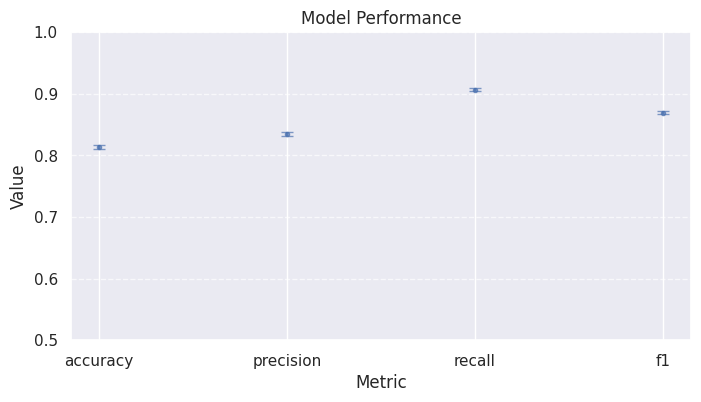

In [86]:
# Plot metrics
fig, ax = plt.subplots(figsize=(8,4))
ax = plot_metrics(evaluation_results, ax,fig, savefig=True, filename="Task2.2_part3_plot.png")

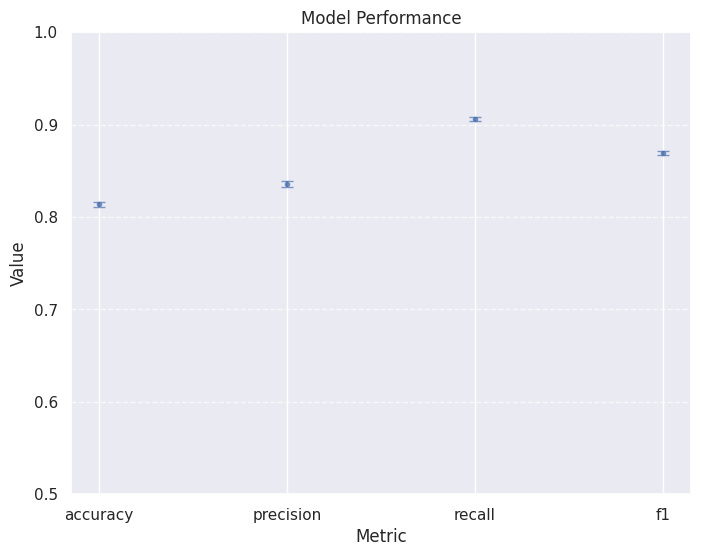

<Axes: title={'center': 'Model Performance'}, xlabel='Metric', ylabel='Value'>

In [68]:
# Plot metrics
fig, ax = plt.subplots(figsize=(8,6))
plot_metrics(evaluation_results, ax,fig, savefig=True, filename="Task2.2_part3_plot.png")

#### Part 4 - Look at the fairness metric associated with each SEX and RAC1P group. Are there any discrepancies?

SEX
RAC1P


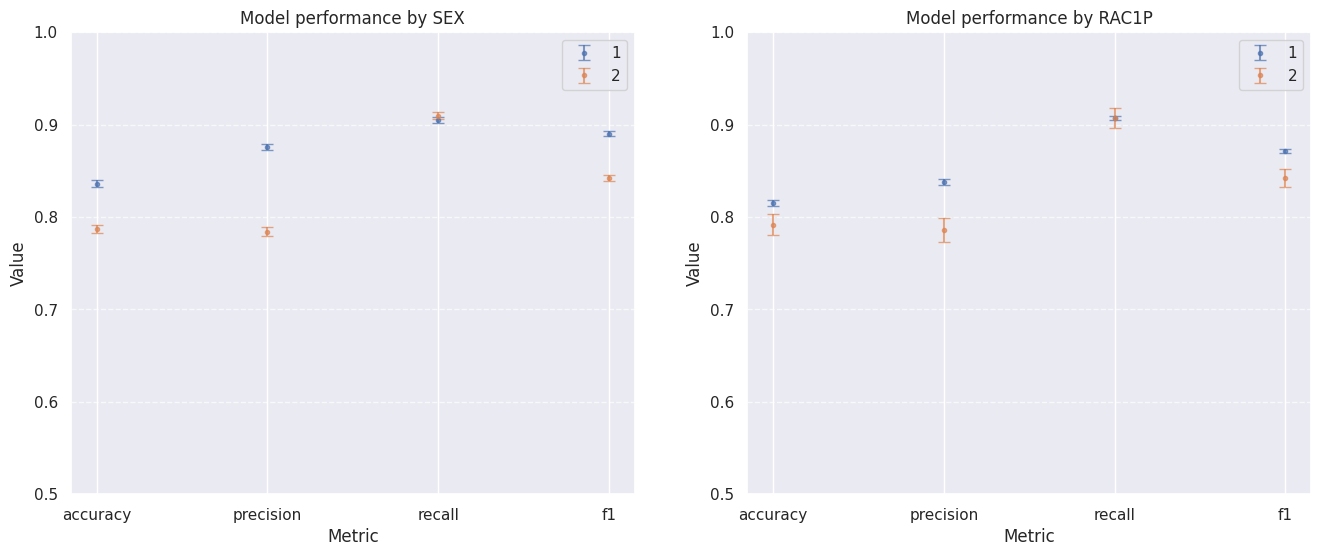

In [83]:
# Generate performance plot split by protected features' values
fig, axes = plt.subplots(1,2, figsize=(16,6))

for i, group_name in enumerate(groups.columns.to_list()):
    
    print(group_name)
    vals = groups[group_name].unique().tolist()
    
    for val in vals:
        
        # Only test set changes, same weights used all the time
        X_test_temp = X_test[group_test[group_name] == val]
        y_test_temp  = y_test[group_test[group_name] == val]

        prob_temp = sigmoid(np.insert(X_test_temp, 0, 1, axis=1).dot(weights))
        y_pred_temp = (prob_temp >= 0.5).astype(int)

        evaluation_results_temp = evaluate_model( y_test_temp,y_pred_temp)

        axes[i] = plot_metrics(evaluation_results_temp, axes[i], fig, label=val, plotfig=False, savefig=False, title=f'Model performance by {group_name}')
    
    axes[i].legend()

outpath = os.path.join(os.getcwd(), "plots", "task2")
if not os.path.exists(outpath):
    os.mkdir(outpath)
fig.savefig(os.path.join(outpath, "Task2.2_part4_plot.png"), dpi=200, bbox_inches='tight' )

### Task 2.3
Use the following arguments in the `opt.fmin_funct`: ` xtol=1e-3, ftol=1e-3, approx_grad=True, maxfun=1000`

In [94]:
# Split already normalized into even smaller pieces, since this part is very expensive computationally
X_train_small, X_test_small, y_train_small, y_test_small, group_train_small, group_test_small = split_dataset(
    features_normalized, labels, groups, N=50)

#### Part 1 - Add Individual Fairness Penalty to your baseline model (refer to Lecture 5 Exercises).

#### Part 2 - Plot Pareto Curve by varying λ = [1e − 3, 5e − 3, 1e − 2, 5e − 2, 0.1, 1], evaluate the performance of the model (using your favourite metric). Plot a curve for each group of protected attributes (i.e. 4 curves). What happens as we increase the penalty? Is there a point where all groups get similar performance metric values?

In [ ]:
# define the values of λ to use
lambdas = [1e-3, 5e-3, 1e-2, 5e-2, 0.1, 1]

# create lists to store the results for each lambda and each metric
accuracy_protected = []
accuracy_unprotected = []
precision_protected = []
precision_unprotected = []
recall_protected = []
recall_unprotected = []
f1_protected = []
f1_unprotected = []

# loop over the lambdas and train the model for each one
for l in lambdas:
    # train the model on the protected group
    X_protected = protected_group[['feature1', 'feature2', 'feature3']].values
    y_protected = protected_group['label'].values
    model_protected = LogisticRegression(penalty='l1', C=1/l, solver='liblinear')
    model_protected.fit(X_protected, y_protected)
    
    # evaluate the model on the protected group
    y_pred_protected = model_protected.predict(X_protected)
    accuracy_protected.append(accuracy_score(y_protected, y_pred_protected))
    precision_protected.append(precision_score(y_protected, y_pred_protected))
    recall_protected.append(recall_score(y_protected, y_pred_protected))
    f1_protected.append(f1_score(y_protected, y_pred_protected))
    
    # train the model on the unprotected group
    X_unprotected = unprotected_group[['feature1', 'feature2', 'feature3']].values
    y_unprotected = unprotected_group['label'].values
    model_unprotected = LogisticRegression(penalty='l1', C=1/l, solver='liblinear')
    model_unprotected.fit(X_unprotected, y_unprotected)
    
    # evaluate the model on the unprotected group
    y_pred_unprotected = model_unprotected.predict(X_unprotected)
    accuracy_unprotected.append(accuracy_score(y_unprotected, y_pred_unprotected))
    precision_unprotected.append(precision_score(y_unprotected, y_pred_unprotected))
    recall_unprotected.append(recall_score(y_unprotected, y_pred_unprotected))
    f1_unprotected.append(f1_score(y_unprotected, y_pred_unprotected))

# plot the Pareto curves
plt.figure(figsize=(8, 6))
plt.plot(accuracy_protected, precision_protected, label='Protected Group')
plt.plot(accuracy_unprotected, precision_unprotected, label='Unprotected Group')
plt.xlabel('Accuracy')
plt.ylabel('Precision')
plt.title('Pareto Curve')
plt.legend()
plt.show()

#### Part 3 - Set λ = 0.1 and evaluate the overall performance of the final model on the Test Set (report uncertainty). Use the same metric as you used in Task 2.2.

In [95]:
weights_fair, q_fair, code_fair   = fit_logistic_l2(np.insert(X_train_small, 0, 1, axis=1), y_train_small, groups=group_train_small,
                            gamma_used=optimal_l2_penalty,lambda_used=0.1, include_fairness=True, aprox_grad=True)


log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872
log 0.9868 fair 0.0001312 l2 0.0002 TOTAL: 0.9872


KeyboardInterrupt: 

In [90]:
# Calculate metrics
prob_fair = sigmoid(np.insert(X_test_small, 0, 1, axis=1).dot(weights_fair))
y_pred_fair = (prob_fair >= 0.5).astype(int)
evaluation_results_fair = evaluate_model( y_test_small, y_pred_fair)

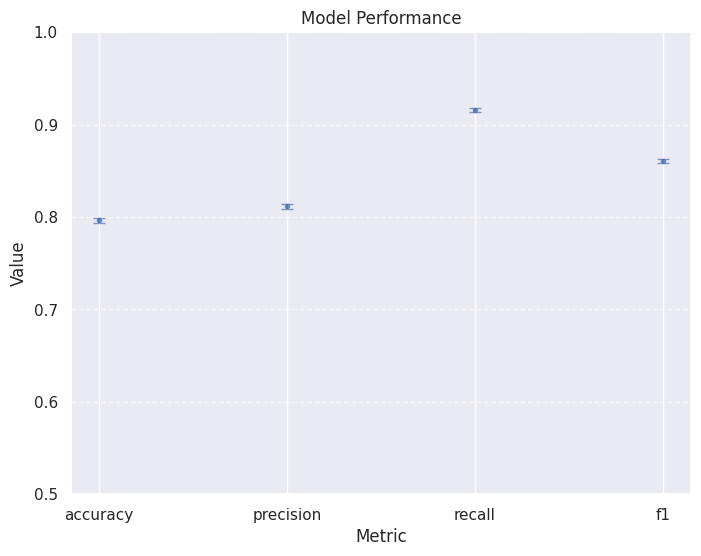

<Axes: title={'center': 'Model Performance'}, xlabel='Metric', ylabel='Value'>

In [91]:
# Plot metrics
fig, ax = plt.subplots(figsize=(8,6))
plot_metrics(evaluation_results_fair, ax,fig, savefig=True, filename="Task2.3_part3_plot.png")

#### Part 4 - Set λ = 0.1 and look at the fairness metric associated with each SEX and RAC1P group. What do you see (compare results to the baseline model)?

### Task 2.4.: Fair PCA

#### Part 1

In [ ]:
# protected columns already dropped in features_normalized so no need to substract 4 for PCA column count
n_components = len(features_normalized.columns)
print(n_components)

pca = PCA(n_components=n_components)  # create a PCA object
X = pca.fit_transform(features_normalized)  # do the math

pca_columns = []
for i in range(n_components):
    pca_columns.append(f"PC{i}")


In [ ]:
pca_no_protected = pd.DataFrame(X, columns=pca_columns)
pca_no_protected


In [ ]:
task_1_merged = pd.concat([pca_no_protected, groups], axis=1)
task_1_merged


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
n_features = X_train.shape[1]
alpha = 0.05  # significance level
# Bonferroni correction for multiple testings
corrected_alpha = alpha / (n_features**2/2)

##############################
# Your code here
##############################


def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = float(round(pearsonr(tmp[r], tmp[c])[1], 4))
    return pvalues


In [ ]:
p_values = calculate_pvalues(task_1_merged)
p_values = p_values.astype('float')


In [ ]:
def heatmap_filtered_relevant(df, p_values, corrected_alpha, title):
    sns.heatmap(df, annot=False, cmap='rocket', linewidths=0.5,
                linecolor='black', mask=p_values > corrected_alpha)
    plt.title(title, fontsize=24)
    plt.tick_params(axis='both', which='both', labelsize=12)
    plt.tight_layout()


In [ ]:
heatmap_filtered_relevant(task_1_merged.corr(method='pearson')[
                          ['SEX', 'RAC1P']], p_values[['SEX', 'RAC1P']], corrected_alpha, 'Pearson Correlation')


#### Part2

In [ ]:
n_components = len(X_test[0])
print(n_components)

pca = PCA(n_components=n_components)  # create a PCA object
X_test_pca = pca.fit_transform(X_test)  # do the math

# project back
X_test_pca_proj_back = pca.inverse_transform(X_test_pca)
rec_errors = X_test - X_test_pca_proj_back


In [ ]:
rec_errors_pd = pd.DataFrame(rec_errors, columns=features_normalized.columns)
rec_errors_pd


In [ ]:
group_test


In [ ]:
task_2_merged = pd.concat(
    [rec_errors_pd.reset_index(), group_test.reset_index()], axis=1)
task_2_merged = task_2_merged.drop(["index"], axis=1)
task_2_merged


In [ ]:
group1_rec_error = task_2_merged.loc[task_2_merged["SEX"] == 1].mean().mean()
group2_rec_error = task_2_merged.loc[task_2_merged["SEX"] == 2].mean().mean()
group3_rec_error = task_2_merged.loc[task_2_merged["RAC1P"] == 1].mean().mean()
group4_rec_error = task_2_merged.loc[task_2_merged["RAC1P"] == 2].mean().mean()


In [ ]:
print(f"Group 1 reconstruction error mean: {group1_rec_error}")
print(f"Group 2 reconstruction error mean: {group2_rec_error}")
print(f"Group 3 reconstruction error mean: {group3_rec_error}")
print(f"Group 4 reconstruction error mean: {group4_rec_error}")


#### Part 3

In [ ]:
from scipy.linalg import null_space
from scipy.linalg import eig


def fair_pca(X, Z):
    SEX_minus_mean = Z["SEX"] - Z["SEX"].mean()
    RAC1P_minus_mean = Z["RAC1P"] - Z["RAC1P"].mean()
    _Z = Z.copy()
    _Z["SEX"] = SEX_minus_mean
    _Z["RAC1P"] = RAC1P_minus_mean

    R = null_space(_Z.to_numpy().T.dot(X))

    rtx = R.T.dot(X.T)
    rtxxt = rtx.dot(X)
    rtxxtr = rtxxt.dot(R)

    eigenvectors, eigenvalues = eig(rtxxtr)
    L = eigenvalues
    U = R.dot(L)
    X_prim = X.dot(U)

    return X_prim, U, _Z


In [ ]:
X_prim, U, _Z = fair_pca(X_train, group_train)


In [ ]:
fair_pca_columns = []
for i in range(len(X_prim[0])):
    fair_pca_columns.append(f"F_PC{i}")


In [ ]:
fair_pca_no_protected = pd.DataFrame(X_prim, columns=fair_pca_columns)
fair_pca_no_protected


In [ ]:
task_3_merged = pd.concat(
    [fair_pca_no_protected.reset_index(), _Z.reset_index()], axis=1)
task_3_merged = task_3_merged.drop(["index"], axis=1)
task_3_merged


In [ ]:
p_values = calculate_pvalues(task_3_merged)
p_values = p_values.astype('float')


In [ ]:
heatmap_filtered_relevant(task_3_merged.corr(method='pearson')[
                          ['SEX', 'RAC1P']], p_values[['SEX', 'RAC1P']], corrected_alpha, 'Pearson Correlation')


#### Part 4

In [ ]:
X_prim_pca, U, _Z = fair_pca(X_test, group_test)
X_prim_pca.shape
# project back

X_test_fair_pca_proj_back = np.dot(X_prim_pca, U.T)
rec_errors = X_test - X_test_fair_pca_proj_back
rec_errors


In [ ]:
rec_errors_fair_pd = pd.DataFrame(
    rec_errors, columns=features_normalized.columns)
rec_errors_fair_pd


In [ ]:
task_4_merged = pd.concat(
    [rec_errors_fair_pd.reset_index(), group_test.reset_index()], axis=1)
task_4_merged = task_4_merged.drop(["index"], axis=1)
task_4_merged


In [ ]:
group1_rec_error = task_4_merged.loc[task_4_merged["SEX"] == 1].mean().mean()
group2_rec_error = task_4_merged.loc[task_4_merged["SEX"] == 2].mean().mean()
group3_rec_error = task_4_merged.loc[task_4_merged["RAC1P"] == 1].mean().mean()
group4_rec_error = task_4_merged.loc[task_4_merged["RAC1P"] == 2].mean().mean()


In [ ]:
print(f"Group 1 reconstruction error mean: {group1_rec_error}")
print(f"Group 2 reconstruction error mean: {group2_rec_error}")
print(f"Group 3 reconstruction error mean: {group3_rec_error}")
print(f"Group 4 reconstruction error mean: {group4_rec_error}")


### Task 2.5

In [ ]:
X_test_fair_pca, _, _ = fair_pca(X_test, group_test)
X_test_fair_pca  # 52 fair PCA components, they suggested using only first 30
# X_test_fair_pca is without protected groups


In [ ]:
group_test
